In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk
import re

In [ ]:
calls = pd.read_csv(r"/content/callsf0d4f5a.csv")
customers=pd.read_csv(r"/content/customers2afd6ea.csv")
sentiment=pd.read_csv(r"/content/sentiment_statisticscc1e57a.csv")
reason=pd.read_csv(r"/content/reason18315ff.csv")

In [ ]:
df=pd.merge(calls,customers,on='customer_id',how='left')
df=pd.merge(df,sentiment,on='call_id',how='left')
df=pd.merge(df,reason,on='call_id',how='left')
df.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason
0,4667960400,2033123310,963118,7/31/2024 23:56,08-01-2024 00:03,08-01-2024 00:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,963118,neutral,angry,-0.04,0.39,Voluntary Cancel
1,1122072124,8186702651,519057,08-01-2024 00:03,08-01-2024 00:06,08-01-2024 00:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,519057,calm,neutral,0.02,0.35,Booking
2,6834291559,2416856629,158319,7/31/2024 23:59,08-01-2024 00:07,08-01-2024 00:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,158319,neutral,polite,-0.13,0.32,IRROPS
3,2266439882,1154544516,488324,08-01-2024 00:05,08-01-2024 00:10,08-01-2024 00:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,488324,neutral,frustrated,-0.20,0.20,Upgrade
4,1211603231,5214456437,721730,08-01-2024 00:04,08-01-2024 00:14,08-01-2024 00:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,721730,neutral,polite,-0.05,0.35,Seating


In [ ]:
df['call_transcript'].nunique()

71810

In [ ]:
df.shape

(71810, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  71810 non-null  int64  
 1   customer_id              71810 non-null  int64  
 2   agent_id_x               71810 non-null  int64  
 3   call_start_datetime      71810 non-null  object 
 4   agent_assigned_datetime  71810 non-null  object 
 5   call_end_datetime        71810 non-null  object 
 6   call_transcript          71810 non-null  object 
 7   customer_name            71810 non-null  object 
 8   elite_level_code         46043 non-null  float64
 9   agent_id_y               71810 non-null  int64  
 10  agent_tone               71593 non-null  object 
 11  customer_tone            71810 non-null  object 
 12  average_sentiment        71701 non-null  float64
 13  silence_percent_average  71810 non-null  float64
 14  primary_call_reason   

In [ ]:
example = df['call_transcript'][50]
print(example)



Agent: Thank you for calling United Airlines customer service, my name is Sarah how can I help you?

Customer: Hi, I'm calling to complain about my missing luggage from flight 123 yesterday. I landed and my bag was nowhere to be found. It's been over 24 hours now and I still don't have it!

Agent: I'm sorry to hear that. Can you confirm your name and flight details for me please so I can take a look into this? 

Customer: It's John Smith, flight number 123 from New York to San Francisco, I arrived yesterday at 5pm. 

Agent: Thanks, just let me pull up your record... *typing noises* okay I see the flight information here. It looks like your bag was delayed in transferring from the inbound flight. These things unfortunately happen sometimes with connecting flights. Let me check the status... it looks like your bag is still at JFK airport waiting to come out on the next flight today. I apologize for the inconvenience. 

Customer: Are you kidding me? Waiting until today? I've been withou

In [ ]:
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


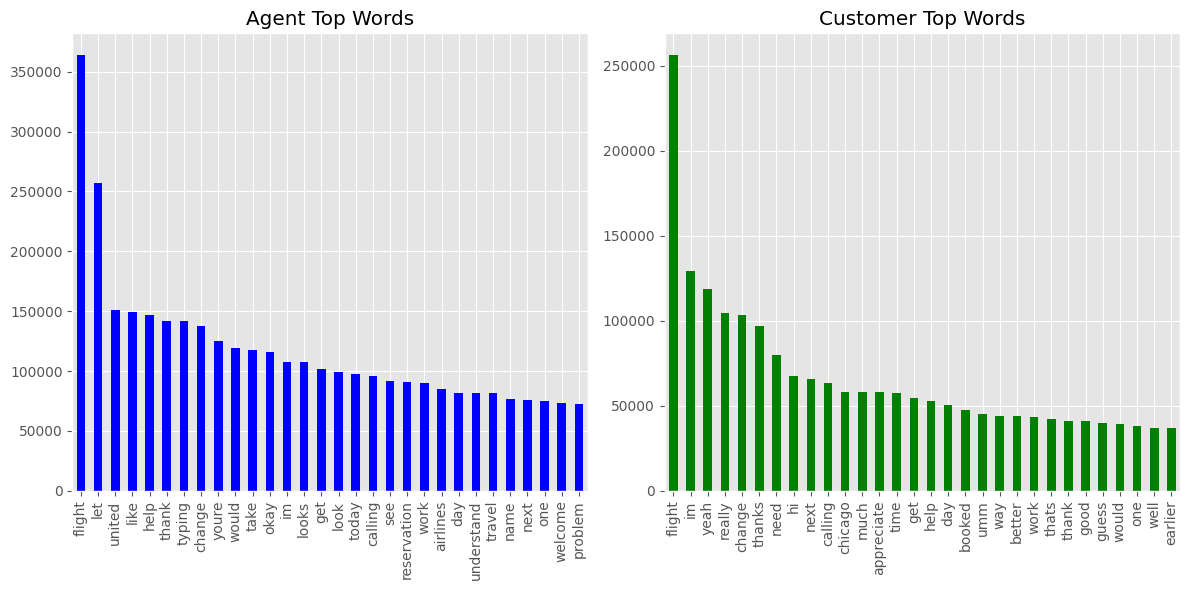

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def tokenize_and_remove_stop_words(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)



def separate_agent_customer(text):
    agent_lines = []
    customer_lines = []

    lines = text.split('\n')

    for line in lines:
        if line.startswith('Agent:'):
            agent_lines.append(line.replace('Agent:', '').strip())
        elif line.startswith('Customer:'):
            customer_lines.append(line.replace('Customer:', '').strip())

    return ' '.join(agent_lines), ' '.join(customer_lines)


df['agent_text'], df['customer_text'] = zip(*df['call_transcript'].apply(lambda x: separate_agent_customer(x)))

df['agent_clean'] = df['agent_text'].apply(lambda x: clean_text(x)).apply(lambda x: tokenize_and_remove_stop_words(x))
df['customer_clean'] = df['customer_text'].apply(lambda x: clean_text(x)).apply(lambda x: tokenize_and_remove_stop_words(x))

# sentiment analysis
df['agent_sentiment'] = df['agent_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['customer_sentiment'] = df['customer_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)


# Perform TF-IDF vectorization on agent and customer text
X_agent = vectorizer.fit_transform(df['agent_clean'])
X_customer = vectorizer.fit_transform(df['customer_clean'])

# Get feature names from TF-IDF vectorizer
agent_feature_names = vectorizer.get_feature_names_out()
customer_feature_names = vectorizer.get_feature_names_out()

# Convert TF-IDF results to DataFrame
df_tfidf_agent = pd.DataFrame(X_agent.todense(), columns=agent_feature_names)
df_tfidf_customer = pd.DataFrame(X_customer.todense(), columns=customer_feature_names)


agent_word_counts = pd.Series(' '.join(df['agent_clean']).split()).value_counts().head(30)
customer_word_counts = pd.Series(' '.join(df['customer_clean']).split()).value_counts().head(30)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
agent_word_counts.plot(kind='bar', color='blue', title='Agent Top Words')
plt.xticks(rotation=90)


plt.subplot(1, 2, 2)
customer_word_counts.plot(kind='bar', color='green', title='Customer Top Words')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
